# 06 TDA 

**Objective:**
* test out KeplerMapper on Spatial Transcriptomics data with different lenses

In [1]:
# %load common.py
import pandas as pd
import numpy as np
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Commonly used constants.

slides = [
    'B02_D1', 'B02_E1', 'B03_C2', 'B03_D2', 'B04_D1',
    'B04_E1', 'B05_D2', 'B05_E2', 'B06_E1', 'B07_C2',
    'N02_C1', 'N02_D1', 'N03_C2', 'N03_D2', 'N04_D1',
    'N04_E1', 'N05_C2', 'N05_D2', 'N06_D2', 'N07_C1']

GT = 'GT'
YEN = 'AB1_StdDev_Yen'
REGION = 'Region_predict'
ASTROCYTE = 'astrocyte'
NEURON = 'neuron'
INTERNEURON = 'interneuron'
AGE = 'age'
DAYS = 'age_days'
MONTHS = 'age_months'
AGE_GT ='age_GT'
SAMPLE_ID = 'sampleID'
SPOT_UID = 'spot_UID'
SLIDE_ID = 'slide_ID'

# The merged data file in Parquet format.

parquet = '/media/tmo/data/work/datasets/02_ST/parquet/'
st_full = parquet + 'st_full'

def read_full(path=st_full):
    return pd.read_parquet(st_full)

def enrich(full):
    # Add age column (young, old)
    full[AGE] = np.where(full[MONTHS] < 10, 'young', 'old')
    
    # Add combined column age_GT.
    full[AGE_GT] = full[[AGE, GT]].apply(lambda x: '_'.join(x), axis=1)
    
    # parse slide ID
    full['slide_ID'] = full[SPOT_UID].apply(lambda x: str(x).split('__')[0])
    
    return full

def read_enriched(path=st_full):
    return enrich(read_full(path))
    
# TODO
# * add 'coarse_region' that joins regions with <500 entries in them into one region OTHER

In [2]:
full = read_enriched()

In [3]:
n_genes = 46454

In [4]:
gene_cols = full.columns[1:n_genes+1]

In [5]:
ex_matrix = full[gene_cols].as_matrix()

In [6]:
ex_matrix.shape

(10327, 46454)

In [40]:
ex_matrix_AB1 = full[full['AB1_StdDev_Yen'] > 0][gene_cols].as_matrix()

In [41]:
ex_matrix_AB1.shape

(5009, 46454)

---

In [42]:
import kmapper as km
from kmapper.cover import Cover
from sklearn.cluster import DBSCAN

In [43]:
mapper = km.KeplerMapper(verbose=1)

In [44]:
yen_lens = full[full['AB1_StdDev_Yen'] > 0]['AB1_StdDev_Yen'].values

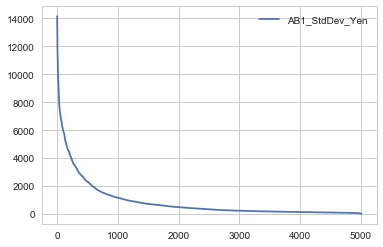

In [45]:
full[full['AB1_StdDev_Yen'] > 0][['AB1_StdDev_Yen']].sort_values(by='AB1_StdDev_Yen', ascending=False).plot(use_index=False)
plt.show()

In [47]:
%%time
graph = mapper.map(yen_lens,
                   ex_matrix_AB1,
                   clusterer=DBSCAN(n_jobs=-1, eps=0.01),
                   coverer=Cover(nr_cubes=50, overlap_perc=0.33))

Mapping on data shaped (5009, 46454) using lens shaped (5009,)

Creating 50 hypercubes.

Created 0 edges and 0 nodes in 0:07:51.347290.
CPU times: user 2min 6s, sys: 5min 29s, total: 7min 35s
Wall time: 7min 51s


In [48]:
mapper.visualize(graph)

ValueError: zero-size array to reduction operation maximum which has no identity

In [49]:
from sklearn.manifold import t_sne

In [51]:
t_sne.TSNE?

Init signature: t_sne.TSNE(n_components=2, perplexity=30.0, early_exaggeration=4.0, learning_rate=1000.0, n_iter=1000, n_iter_without_progress=30, min_grad_norm=1e-07, metric='euclidean', init='random', verbose=0, random_state=None, method='barnes_hut', angle=0.5)
Docstring:     
t-distributed Stochastic Neighbor Embedding.

t-SNE [1] is a tool to visualize high-dimensional data. It converts
similarities between data points to joint probabilities and tries
to minimize the Kullback-Leibler divergence between the joint
probabilities of the low-dimensional embedding and the
high-dimensional data. t-SNE has a cost function that is not convex,
i.e. with different initializations we can get different results.

It is highly recommended to use another dimensionality reduction
method (e.g. PCA for dense data or TruncatedSVD for sparse data)
to reduce the number of dimensions to a reasonable amount (e.g. 50)
if the number of features is very high. This will suppress some
noise and speed up the c